# Toy example: 
In this notebook all model paremeters, i.e:  noise variance, hyper-parameters of activations and components, variational distributions, are learned simultaneously by maximazing the marginal likelihood.

In [1]:
%matplotlib inline
import sys 
sys.path.append('../../../')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow, gpitch
reload(gpitch)
from gpitch.amtgp import logistic
from scipy.fftpack import fft, ifft, ifftshift
from scipy import signal

In [2]:
gpitch.amtgp.init_settings()
plt.rcParams['figure.figsize'] = (16, 3)  # set plot size

In [3]:
np.random.seed(2)
Nc = 10  # number of partials
var = 0.25*np.random.rand(Nc)  # variances
leng = 0.5*np.random.rand()  # lengthscales
f0 = 220.0
freq = f0*np.asarray(range(1, Nc+ 1)) + np.sqrt(100.)*np.random.randn(Nc) # frequencies
kern1 = gpitch.kernels.MaternSpecMixSL(input_dim=1, lengthscales=leng, variances=var, frequencies=freq)
kern2 = gpflow.kernels.Matern32(input_dim=1, lengthscales=0.05, variance=10.)

In [4]:
f0*np.asarray(range(1, Nc+ 1))

array([  220.,   440.,   660.,   880.,  1100.,  1320.,  1540.,  1760.,
        1980.,  2200.])

In [5]:
print freq
print leng
print var

[  208.89272244   440.88580067   646.45769458   880.58270689  1104.80084844
  1323.86990512  1552.10468169  1759.79870455  1980.10393948  2191.67162054]
0.310566916385
[ 0.10899873  0.00648156  0.13741562  0.1088306   0.10509195  0.08258371
  0.05116216  0.15481774  0.07491367  0.06670682]


In [6]:
N, fs = 2400, 16e3
x = np.linspace(0., (N-1.)/fs, N).reshape(-1, 1)
Kcom = kern1.compute_K_symm(x)
Kact = kern2.compute_K_symm(x)

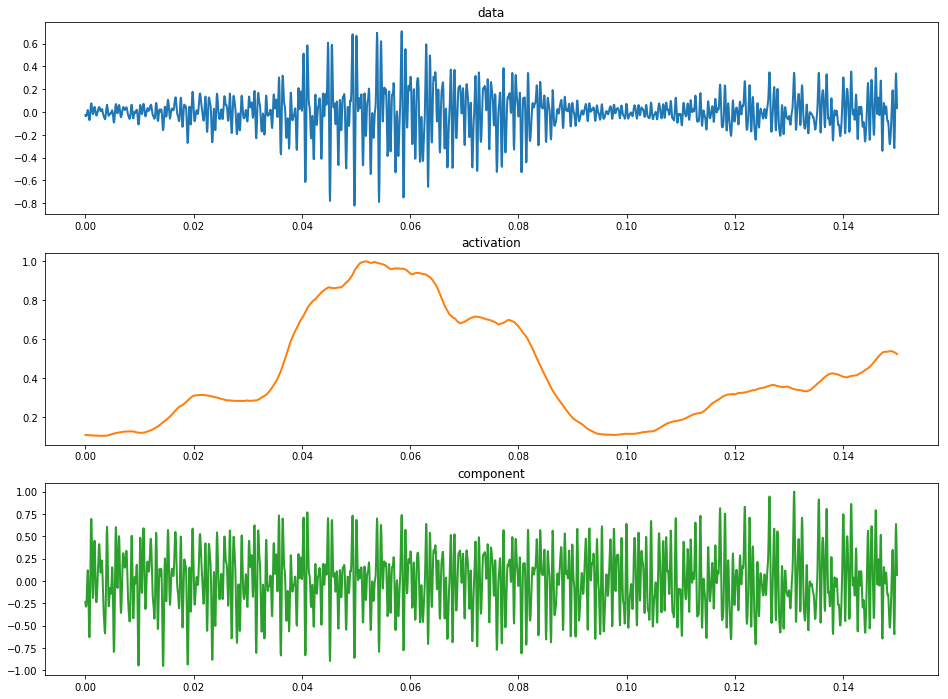

In [7]:
noise_var = 1e-5
com = np.random.multivariate_normal(np.zeros((N)), Kcom, 1).reshape(-1, 1)
com /= np.max(np.abs(com))
g = np.random.multivariate_normal(np.zeros((N)), Kact, 1).reshape(-1, 1)
act = logistic(g)
act /= np.max(act)
y = act*com + np.sqrt(noise_var)*np.random.randn(N,1)

plt.figure(figsize=(16, 12))
plt.subplot(3,1,1), plt.title('data')
plt.plot(x, y, 'C0', lw=2 )
plt.subplot(3,1,2), plt.title('activation')
plt.plot(x, act, 'C1', lw=2)
plt.subplot(3,1,3), plt.title('component')
plt.plot(x, com, 'C2', lw=2)

(0, 2000)

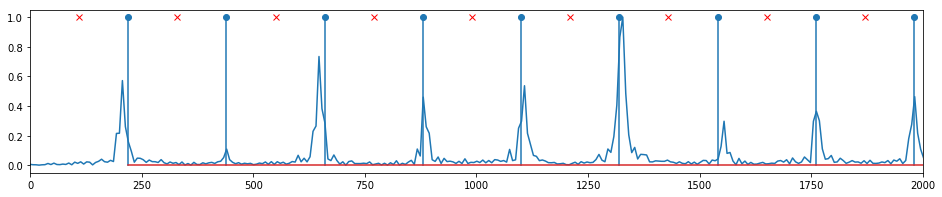

In [8]:
N = y.size
Y = fft(y.reshape(-1,)) #  FFT data
S =  2./N * np.abs(Y[0:N//2]) #  spectral density data
F = np.linspace(0, fs/2., N//2) #  frequency vector


aux1 = np.ones((Nc, 1))
aux2 = f0*np.asarray(range(1, Nc+1))

aux3 = np.ones((Nc + 1, 1))
aux4 = f0*np.asarray(range(1, Nc+2)) - 0.5*f0

plt.figure()
plt.plot(F, S/np.max(np.abs(S)))
plt.stem(aux2, aux1 )
plt.plot(aux4, aux3, 'xr' )
plt.xlim([0, 2000])


(0, 2000)

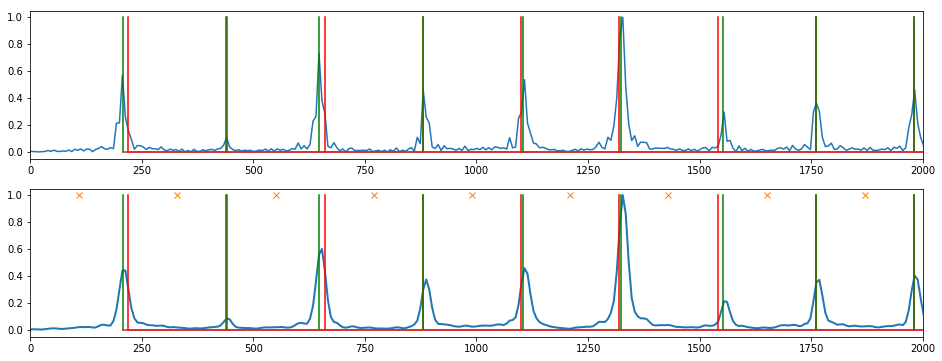

In [9]:
win = signal.hann(6)
Ss = signal.convolve(S, win, mode='same') / sum(win)

plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
plt.plot(F, S / np.max(S))
plt.stem(aux2, aux1, 'r', markerfmt=" " )
plt.stem(np.asarray(freq), aux1, 'g' ,markerfmt=" ")
plt.xlim([0, 2000])

plt.subplot(2,1,2)
plt.plot(F, Ss / np.max(Ss), lw=2)
plt.stem(aux2, aux1, 'r', markerfmt=" " )
plt.stem(np.asarray(freq), aux1, 'g' ,markerfmt=" ")
plt.plot(aux4, aux3, 'xC1' )
plt.xlim([0, 2000])

(0, 2000)

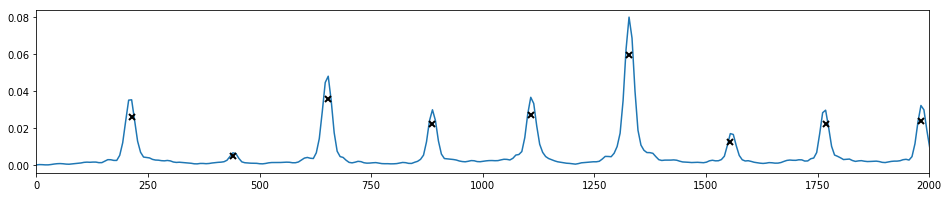

In [10]:
F_star, S_star= gpitch.amtgp.init_com_params(y=y, fs=fs, Nh=Nc, ideal_f0=f0, scaled=True)
plt.figure()
plt.plot(F, Ss)
plt.plot(F_star, S_star, 'xk', mew=2)
plt.xlim([0, 2000])

In [11]:
print var

[ 0.10899873  0.00648156  0.13741562  0.1088306   0.10509195  0.08258371
  0.05116216  0.15481774  0.07491367  0.06670682]


In [12]:
kern1

Name,values,prior,constraint
unnamed.frequency_1,[ 208.89272244],None,+ve
unnamed.frequency_10,[ 2191.67162054],None,+ve
unnamed.frequency_2,[ 440.88580067],None,+ve
unnamed.frequency_3,[ 646.45769458],None,+ve
unnamed.frequency_4,[ 880.58270689],None,+ve
unnamed.frequency_5,[ 1104.80084844],None,+ve
unnamed.frequency_6,[ 1323.86990512],None,+ve
unnamed.frequency_7,[ 1552.10468169],None,+ve
unnamed.frequency_8,[ 1759.79870455],None,+ve
unnamed.frequency_9,[ 1980.10393948],None,+ve


In [13]:
kern2

Name,values,prior,constraint
unnamed.lengthscales,[ 0.05],None,+ve
unnamed.variance,[ 10.],None,+ve


In [14]:
kern_com = gpitch.kernels.MaternSpecMixSL(input_dim=1, lengthscales=1., variances=S_star, frequencies=F_star, Nc=1)
kern_act = gpflow.kernels.Matern32(1)

In [15]:
ws, dec = N//1, 80  # samples per window, decimation factor
m = gpitch.modpdet.ModPDet(x=x, y=y, kern_com=kern_com, kern_act=kern_act, ws=ws, dec=dec, whiten=True)

m.model.kern1.fixed = True
m.model.kern1.lengthscales.fixed = False
m.model.kern1.lengthscales.transform = gpflow.transforms.Logistic(0., 0.1)
m.model.kern1.frequency_1.fixed = False
m.model.kern1.frequency_2.fixed = False
m.model.kern1.frequency_3.fixed = False
m.model.kern1.frequency_4.fixed = False
m.model.kern1.frequency_5.fixed = False
m.model.kern1.frequency_6.fixed = False
m.model.kern1.frequency_7.fixed = False
m.model.kern1.frequency_8.fixed = False
m.model.kern1.frequency_9.fixed = False
m.model.kern1.frequency_10.fixed = False
m.model.kern2.fixed = False
m.model.likelihood.noise_var.fixed = False

In [16]:
maxiter, restarts = 500, 5
init_hyper, learnt_hyper, mse = m.optimize_restart(maxiter=maxiter, restarts=restarts)

| len: 0.5762, 0.0973 | sig: 6.1654, 6.1325 | noise_var: 0.0929, 0.0028 | l_com: 0.0245, 0.0999 |
| len: 0.0105, 0.1142 | sig: 11.6273, 9.5941 | noise_var: 0.0149, 0.0028 | l_com: 0.0958, 0.0999 |
| len: 0.4346, 0.2751 | sig: 11.7457, 12.5604 | noise_var: 0.0570, 0.0038 | l_com: 0.0802, 0.1000 |
| len: 0.9602, 0.2541 | sig: 10.2784, 10.8431 | noise_var: 0.0672, 0.0032 | l_com: 0.0397, 0.0999 |
| len: 0.4599, 0.2008 | sig: 9.0277, 9.4637 | noise_var: 0.0734, 0.0030 | l_com: 0.0431, 0.1000 |


In [17]:
m.model.kern2.lengthscales = learnt_hyper[0].mean().copy()
m.model.kern2.variance = learnt_hyper[1].mean().copy()
m.model.likelihood.noise_var = learnt_hyper[2].mean().copy()
m.model.kern1.lengthscales = learnt_hyper[3].mean().copy()

m.model.optimize(disp=1, maxiter=500)

      fun: -3312.1672485727754
 hess_inv: <1998x1998 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.18694647,  0.32221872,  0.03054675, ...,  0.17305578,
       -0.24984898,  0.1535148 ])
  message: 'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 557
      nit: 501
   status: 1
  success: False
        x: array([  2.07373827e+02,   2.20308293e+03,   4.40837849e+02, ...,
         1.74157998e-01,  -5.50962330e-01,   4.19183192e-01])

In [18]:
m.model.kern1.fixed = True
m.model.kern2.fixed = True
m.model.likelihood.noise_var.fixed = True
m.model.optimize(disp=1, maxiter=500)

      fun: -3312.870115536713
 hess_inv: <1984x1984 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00403381, -0.00410048, -0.00901305, ..., -0.00629543,
        0.00923554, -0.02092019])
  message: 'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 528
      nit: 501
   status: 1
  success: False
        x: array([ 0.07139426, -0.9193558 , -5.75513628, ...,  0.20359909,
       -0.49917443,  0.40358377])

In [19]:
print freq

[  208.89272244   440.88580067   646.45769458   880.58270689  1104.80084844
  1323.86990512  1552.10468169  1759.79870455  1980.10393948  2191.67162054]


In [20]:
m.model.kern1

Name,values,prior,constraint
kern1.frequency_1,[ 207.37382767],None,[FIXED]
kern1.frequency_10,[ 2203.08293302],None,[FIXED]
kern1.frequency_2,[ 440.83785028],None,[FIXED]
kern1.frequency_3,[ 647.54689121],None,[FIXED]
kern1.frequency_4,[ 881.91583981],None,[FIXED]
kern1.frequency_5,[ 1105.60026133],None,[FIXED]
kern1.frequency_6,[ 1323.22229438],None,[FIXED]
kern1.frequency_7,[ 1557.54373347],None,[FIXED]
kern1.frequency_8,[ 1762.40497368],None,[FIXED]
kern1.frequency_9,[ 1979.75058574],None,[FIXED]


In [21]:
m.model.kern2

Name,values,prior,constraint
kern2.lengthscales,[ 0.07710293],None,[FIXED]
kern2.variance,[ 9.77240631],None,[FIXED]


In [22]:
print m.model.likelihood.noise_var

noise_var transform:[0.0, 0.1] prior:None [FIXED]
[ 0.0027493]


(0.04, 0.05)

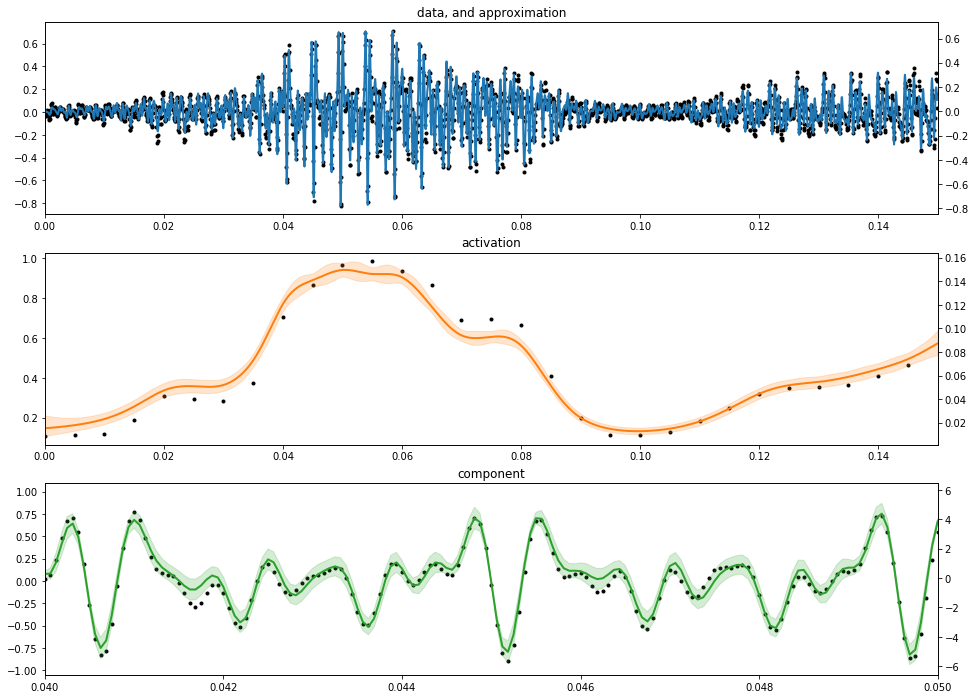

In [26]:
mean_f, var_f = m.model.predict_f(x)
mean_g, var_g = m.model.predict_g(x)
mean_act = logistic(mean_g)

mean_f = mean_f.reshape(-1,)
var_f = var_f.reshape(-1,)
mean_g = mean_g.reshape(-1,)
var_g = var_g.reshape(-1,)
x_plot = x.reshape(-1,).copy()


xla = 0.0
xlb = 0.15
plt.figure(figsize=(16, 12))
plt.subplot(3,1,1), plt.title('data, and approximation')
plt.plot(x_plot, y, '.k') 
plt.twinx()
plt.plot(x_plot, logistic(mean_g)*mean_f, lw=2)
plt.xlim([xla, xlb])

plt.subplot(3,1,2), plt.title('activation')

plt.plot(x_plot[::dec], act[::dec], '.k')
plt.twinx()
plt.plot(x_plot, mean_act, 'C1', lw=2)
plt.fill_between(x_plot, logistic(mean_g-2*np.sqrt(var_g)), logistic(mean_g+2*np.sqrt(var_g)), color='C1', alpha=0.2)
plt.xlim([xla, xlb])

plt.subplot(3,1,3), plt.title('component')
plt.plot(x_plot, com, '.k')
plt.twinx()
plt.plot(x_plot, mean_f, 'C2', lw=2)
plt.fill_between(x_plot, mean_f-2*np.sqrt(var_f), mean_f+2*np.sqrt(var_f), color='C2', alpha=0.2)
plt.xlim([0.04, 0.05])

(0.0, 0.15)

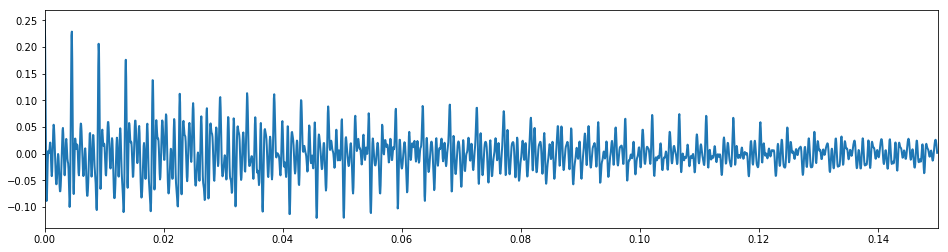

In [24]:
x_eval = x.copy() 
k_plot_model = m.model.kern1.compute_K(x_eval, np.asarray(0.).reshape(-1,1))
k_plot_sample = kern1.compute_K(x_eval, np.asarray(0.).reshape(-1,1))

plt.figure(figsize=(16, 4))
plt.plot(x_eval, k_plot_model, lw=2)
plt.xlim([0., 0.15])

(0, 3000)

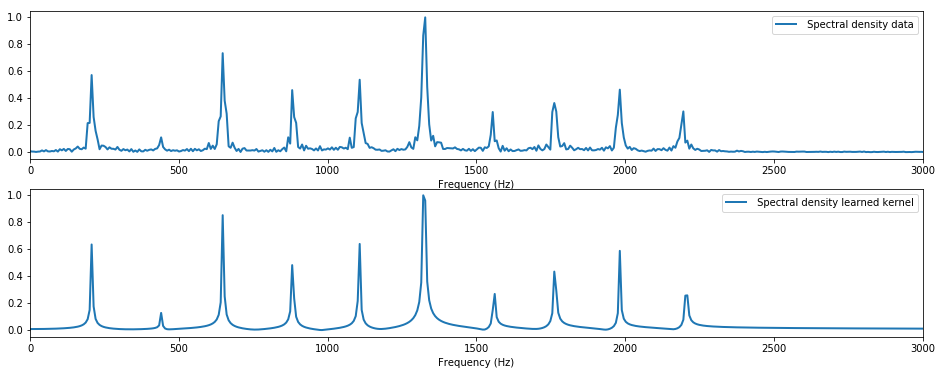

In [25]:
N = x_eval.size
Yk1 = fft(k_plot_model.reshape(-1,)) #  FFT data
Sk1 =  2./N * np.abs(Yk1[0:N//2]) #  spectral density data

plt.figure(figsize=(16, 6))
plt.subplot(2, 1, 1)
plt.plot(F, S / np.max(np.abs(S)), lw=2)
plt.legend([' Spectral density data'])
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 3000])

plt.subplot(2, 1, 2)
plt.plot(F, Sk1 / np.max(np.abs(Sk1)), lw=2)
plt.legend([' Spectral density learned kernel'])
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 3000])